In [1]:
from nem.util import load_songs
from openTSNE import TSNE, affinity, initialization, TSNEEmbedding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

seed = 12261532

,track_number,disc_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,popularity
count,755472.000000,755472.000000,755472.000000,755472.00000,755472.000000,755472.000000,755472.000000,755472.000000,755472.000000,755472.000000,755472.000000,755472.000000,755472.000000,7.554720e+05,755472.000000,755472.000000,755472.000000
mean,7.900534,1.075849,0.484203,0.49944,5.198528,0.710575,0.670189,0.082996,0.461392,0.290231,0.207616,0.419871,0.835231,2.502953e+05,3.828190,2006.472084,10.107353
std,6.196032,0.347523,0.193627,0.30273,3.535295,0.109860,0.470145,0.111872,0.390439,0.379642,0.190283,0.272948,0.221776,1.557933e+05,0.565258,11.670717,13.464069
min,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,0.000000,1900.000000,0.000000
25%,3.000000,1.000000,0.341000,0.22300,2.000000,0.649478,0.000000,0.035600,0.041700,0.000008,0.096700,0.179000,0.664521,1.734000e+05,4.000000,2001.000000,0.000000
50%,7.000000,1.000000,0.490000,0.51300,5.000000,0.743924,1.000000,0.044700,0.418000,0.009520,0.126000,0.391000,0.826807,2.244000e+05,4.000000,2008.000000,4.000000
75%,11.000000,1.000000,0.628000,0.76700,8.000000,0.792902,1.000000,0.071700,0.886000,0.740000,0.253000,0.639000,0.974259,2.876670e+05,4.000000,2015.000000,15.000000
max,50.000000,13.000000,1.000000,1.00000,11.000000,1.000000,1.000000,0.968000,0.996000,1.000000,1.000000,1.000000,1.763450,5.764624e+06,5.000000,2020.000000,95.000000


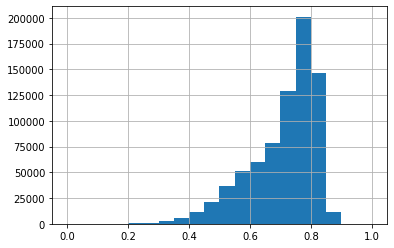

In [2]:
songs = load_songs('../songs_filtered.csv')

songs.tempo = songs.tempo / 140
songs.loudness = (songs.loudness - songs.loudness.min()) / (songs.loudness.max() - songs.loudness.min())
songs.loudness.hist(bins=20)

songs.describe()

In [3]:
# only 6 most genres
genre_counts = pd.Series(songs.metagenre).value_counts()
genres_to_keep = genre_counts.iloc[1:7]
print(genres_to_keep)

classical        110907
rock              42575
rap & hip-hop     40892
metal             33716
folk              32347
jazz              21592
Name: metagenre, dtype: int64


In [16]:
features = [
    'danceability',
    'energy',
    #'key',
    #'loudness',
    #'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',  # extremly discriminative!
    'liveness',
    'valence',
    'tempo'
]
mask = (songs['metagenre'] != 'unknown')
X = songs[features].loc[mask].values
y = songs['metagenre'].loc[mask].values

# remove genres
mask = np.isin(y, genres_to_keep.index)
X = X[mask]
y = y[mask]

# subsample
genre_weights = 1 / len(genres_to_keep) /  (genres_to_keep / genres_to_keep.sum())
probas = genre_weights[y]
probas /= probas.sum()
indices = np.random.choice(len(X), size=40000, replace=False, p=probas)
X = np.ascontiguousarray(X[indices])
y = np.ascontiguousarray(y[indices])

In [17]:
"""
tsne = TSNE(
    perplexity=30,
    metric="cosine",
    n_jobs=8,
    random_state=seed,
    verbose=True,
)

embeddings = tsne.fit(X)
"""

'\ntsne = TSNE(\n    perplexity=30,\n    metric="cosine",\n    n_jobs=8,\n    random_state=seed,\n    verbose=True,\n)\n\nembeddings = tsne.fit(X)\n'

In [18]:
initial_embeddings = initialization.pca(X, random_state=seed)

In [19]:
affinities = affinity.Multiscale(
    X,
    perplexities=[200, 800],
    metric="cosine",
    n_jobs=8,
    random_state=seed,
    verbose=True,
)

===> Finding 2400 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 118.86 seconds
===> Calculating affinity matrix...


In [1]:
tsne = TSNEEmbedding(
    initial_embeddings,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)

embeddings_1 = tsne.optimize(n_iter=150, exaggeration=10, momentum=0.4)
plt.scatter(embeddings_1[:, 0], embeddings_1[:, 1], s=0.3)

NameError: name 'TSNEEmbedding' is not defined

In [ ]:
embeddings_2 = tsne.optimize(n_iter=500, momentum=0.8)

===> Running optimization with exaggeration=1.00, lr=3333.33 for 500 iterations...
Iteration   50, KL divergence 2.0585, 50 iterations in 20.0496 sec
Iteration  100, KL divergence 1.7055, 50 iterations in 20.7051 sec
Iteration  150, KL divergence 1.5798, 50 iterations in 20.7697 sec
Iteration  200, KL divergence 1.5164, 50 iterations in 20.4549 sec
Iteration  250, KL divergence 1.4795, 50 iterations in 20.8159 sec
Iteration  300, KL divergence 1.4561, 50 iterations in 21.2052 sec
Iteration  350, KL divergence 1.4405, 50 iterations in 21.7598 sec
Iteration  400, KL divergence 1.4299, 50 iterations in 21.9657 sec
Iteration  450, KL divergence 1.4223, 50 iterations in 22.1280 sec
Iteration  500, KL divergence 1.4167, 50 iterations in 21.3450 sec
   --> Time elapsed: 211.20 seconds


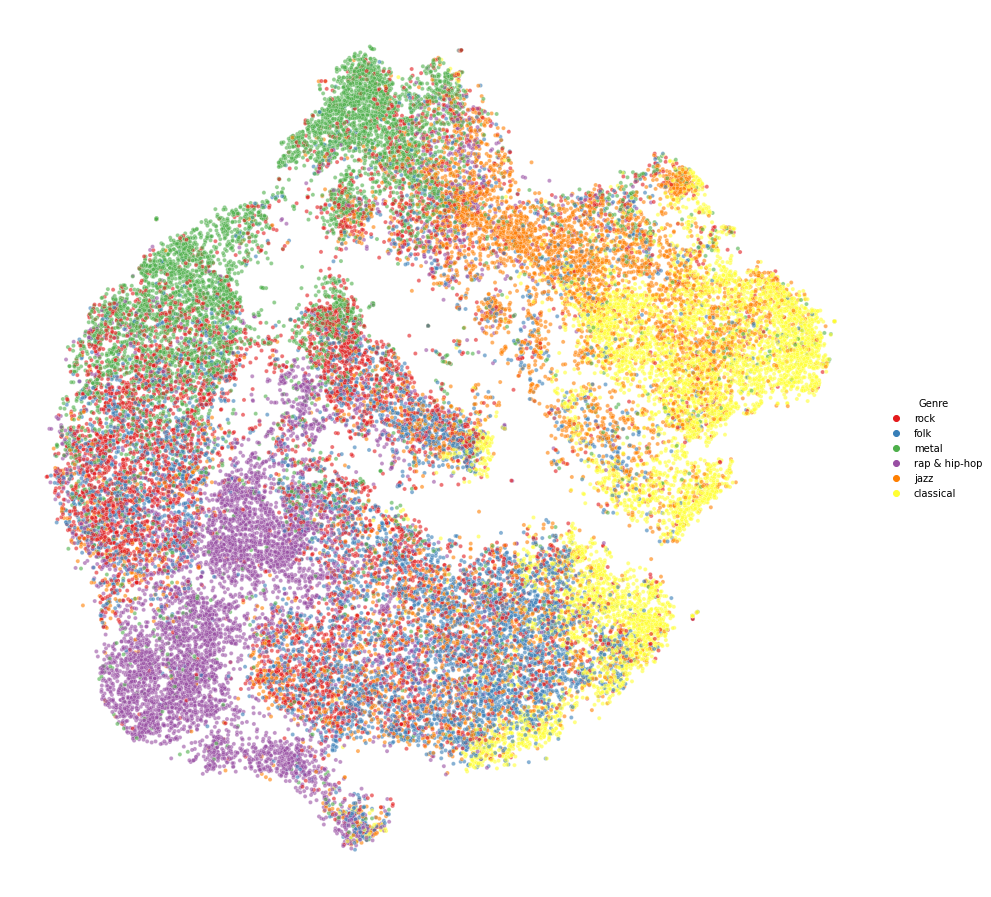

In [ ]:
import seaborn as sns

data = pd.DataFrame({
    'x': embeddings_2[:,0],
    'y': embeddings_2[:,1],
    'Genre': y
})
g = sns.relplot(x='x', y='y', hue='Genre', data=data, height=13, alpha=0.6, s=17, palette='Set1')
g.set(xticklabels=[], xlabel=None)
g.set(yticklabels=[], ylabel=None)
sns.despine(bottom=True, left=True)
plt.gca().tick_params(bottom=False, left=False)